In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import readsav

import re

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

from matplotlib.pylab import *
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter

rcParams['figure.figsize'] = (10,8)
rcParams['font.size'] = 22

import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import loadfilt as lf
import lymanAbs as lyA
import buildFluxTables as bft

import linecache
import os
import subprocess
import glob
import gc

In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def div_formatter(x,pos):
    return format(x/1000, '.1f')
divfmt  = FuncFormatter(div_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [3]:
# Setup the cosmology used in the runs
# This provides comoving distance, lumin distance, etc... 
# THis is Seth's cosmology
cosmo = FlatLambdaCDM(H0=73.2, Om0=0.24, Ob0=0.0449,name='myCosmo')

In [4]:
cosmo.luminosity_distance(z=1.0)
# Matches Ned's calc: The luminosity distance DL is 6560.5 Mpc or 21.398 Gly. 

<Quantity 6560.467651039068 Mpc>

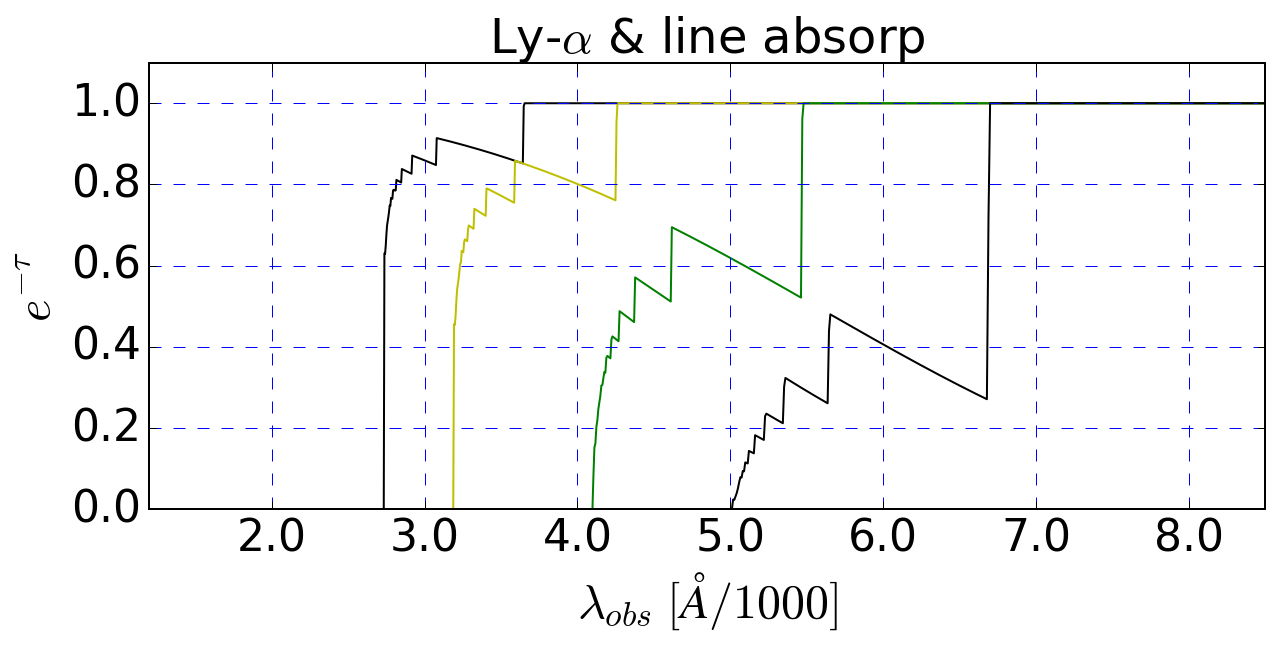

In [5]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
lamRange = np.logspace(1.95,5.7,5500)
ax.plot(lamRange,lyA.lyTauC(2.0)(lamRange),'k-',
        lamRange,lyA.lyTauC(2.5)(lamRange),'y-',
        lamRange,lyA.lyTauC(3.5)(lamRange),'g-',
        lamRange,lyA.lyTauC(4.5)(lamRange),'k-')
ax.set_xlim([1200,8500])
ax.set_ylim([1e-9,1.1])
ax.set_ylim([0,1.1])
#ax.set_yscale('log')
ax.set_ylabel(r'$e^{-\tau}$', size=labelsize)
ax.set_xlabel(r'$\lambda_{obs}\; [\AA/1000]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.xaxis.set_major_formatter(divfmt)
ax.set_title(r'Ly-$\alpha$ & line absorp',size=labelsize)


# Load SB99 data... 

In [6]:
# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
# REMEMBER, SB99 data is for a population of 1e6 M_sun
SB99Path = '/Users/earnric/OneDrive/STARBURST99-runs/' # Home computer dir... 
SB99Dirs = ['padova0004/','padova004/','padova008/','padova02/']
Zs       = [0.0004, 0.004, 0.008, 0.02]
SB99FilePat = 'padova*.spectrum1'

# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
for i, (Z, SB99Dir) in enumerate(zip(Zs,SB99Dirs)):
    SB99FilePattern = SB99Path + SB99Dir + SB99FilePat 
    SB99Files   = glob.glob(SB99FilePattern)  # All the files in the dir... should be one!
    if len(SB99Files) != 1:
        print('Error: too many files in an SB99 dir! - ',SB99Path + SB99Dir)
        sys.exit()
    SB99Data    = np.loadtxt(SB99Files[0],skiprows=6)
    if i == 0:
        SB990004 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 1:
        SB99004 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 2:
        SB99008 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 3:
        SB9902 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    # We now have:
    # [[log age, waveln, flux], [], ...]


In [9]:
np.unique(SB9902[:,0])[0:20]

array([ 4.        ,  6.30319606,  6.60314437,  6.77887447,  6.90363252,
        7.00043408,  7.07954301,  7.14643814,  7.20439133,  7.25551371,
        7.30124709,  7.34262004,  7.38039216,  7.41514035,  7.44731311,
        7.477266  ,  7.50528567,  7.53160663,  7.55642312,  7.57989787])

In [10]:
jwstFilters   = lf.loadJWSTFilters(suppress=True)
hubbleFilters = lf.loadHubbleFilters(suppress=True)
jhkFilters    = lf.loadJHKFilters(suppress=True)

In [40]:
redshifts    = [2.0,3.0,4.0,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0]
# redshifts    = [14.0,15.0,16.0]
sb99List  = [SB990004, SB99004, SB99008, SB9902]
sb99Names = ["SB990004", "SB99004", "SB99008", "SB9902"]
# sb99List  = [SB9902]
# sb99Names = ["SB9902"]
hdr = 'LogAge, redshift, '
hdr += ', '.join([jFilt for jFilt in jwstFilters])
hdr += ', '
hdr += ', '.join([hFilt for hFilt in hubbleFilters])
hdr += ', '
hdr += ', '.join([jFilt for jFilt in jhkFilters])
fmtStr = '%.4f, %.1f, '
fmtStr += ', '.join(['%.4e' for ii in arange(len(jwstFilters)+len(hubbleFilters)+len(jhkFilters))]) 
print(hdr)
for sb99Data, fname in zip(sb99List,sb99Names):
    ages = np.unique(sb99Data[:,0]) # Get the list of ages
    # Get the log age, wavelength & Luminosity/s/Ang
    allAges = sb99Data[:,0]
    wavelns = sb99Data[:,1] * u.Angstrom
    LperA   = sb99Data[:,2] * u.erg / u.second / u.angstrom
    for z in redshifts:
        prevAge = 0.0
        outfile = []
        print("working {} at z={:.1f}".format(fname,z))
        absorb = lyA.lyTauC(z) # Create a lyman forest absorption function for z... ***** NEW truncated absorption
        for age in ages: # Once for each age group in the list
            if age - prevAge < 0.025:
                continue # We don't super-tight spacing in age... 
            print("log age={:.4f}".format(age))
            prevAge = age
            ageCond = (allAges == age) # select records based on log age field... 
            # Convert to freq & Lumin/s/Hz
            freq = (wavelns[ageCond][::-1]).to(u.Hz, equivalencies=u.spectral()) # Reverse array order
            LperHz = (LperA[ageCond] * wavelns[ageCond]**2/astropy.constants.c).to(u.erg/u.s/u.Hz)[::-1] # Reverse array order...

            rsWaveln, rsLperA  = lyA.rsSEDwavelen(wavelns[ageCond], LperA[ageCond], z) # Redshift SED in wavelen
            rsFreq,   rsLperHz = lyA.rsSEDfreq(freq, LperHz, z)      # Redshift SED in freq
            lyForFluxHz = (rsLperHz * absorb(rsWaveln[::-1]))
            
            # Need to extract only the data for one sed (at a single age)
            # to compute the flux in the filters
            rsWavelnOneAge    = rsWaveln
            rsFreqOneAge      = rsFreq
            lyForFluxHzOneAge = lyForFluxHz
            # Create first part [log age, z, ...]
            # Flux is in erg/s/Hz/cm^2
            jwstNormFlux = np.array([np.trapz(jwstFilters[aFilt](rsWavelnOneAge[::-1])/rsFreqOneAge,rsFreqOneAge).value for aFilt in jwstFilters])
            jwstNormFlux[jwstNormFlux <= 0.0] = -1.0
            jwstFlux = np.array([(np.trapz(jwstFilters[aFilt](rsWavelnOneAge[::-1])*lyForFluxHzOneAge/rsFreqOneAge,rsFreqOneAge)).value
                        for aFilt in jwstFilters])
            jwstFlux[jwstFlux < 1e-90] = 0.0
            jwstFlux   = np.divide(jwstFlux,jwstNormFlux).tolist()
            
            hubbNormFlux = np.array([np.trapz(hubbleFilters[aFilt](rsWavelnOneAge[::-1])/rsFreqOneAge,rsFreqOneAge).value for aFilt in hubbleFilters])
            hubbNormFlux[hubbNormFlux <= 0.0] = -1.0
            hubbFlux = np.array([(np.trapz(hubbleFilters[aFilt](rsWavelnOneAge[::-1])*lyForFluxHzOneAge/rsFreqOneAge,rsFreqOneAge)).value
                        for aFilt in hubbleFilters])   
            hubbFlux[hubbFlux < 1e-90] = 0.0
            hubbFlux = np.divide(hubbFlux,hubbNormFlux).tolist()
            
            jhkNormFlux = np.array([np.trapz(jhkFilters[aFilt](rsWavelnOneAge[::-1])/rsFreqOneAge,rsFreqOneAge).value for aFilt in jhkFilters])
            jhkNormFlux[jhkNormFlux <= 0.0] = -1.0
            jhkFlux = np.array([(np.trapz(jhkFilters[aFilt](rsWavelnOneAge[::-1])*lyForFluxHzOneAge/rsFreqOneAge,rsFreqOneAge)).value
                        for aFilt in jhkFilters])
            jhkFlux[jhkFlux < 1e-90] = 0.0
            jhkFlux = np.divide(jhkFlux,jhkNormFlux).tolist()

            aLine = [age] + [z] + jwstFlux + hubbFlux + jhkFlux
            outfile.append(aLine)
        filename = fname + "_" + str(z) + ".gz"
        print('writing {}'.format(filename))
        np.savetxt(filename, outfile, fmt=fmtStr, delimiter=', ', header=hdr)

LogAge, redshift, f115w, f150w, f430m, f090w, f360m, f140m, f444w, f410m, f182m, f200w, f162m, f460m, f335m, f070w, f480m, f277w, f356w, f210m, f250m, f300m, F125W_WFC3, F105W_WFC3, F275W_WFC3, F775W_ACS, F098M_WFC3, F850LP_ACS, F435W_ACS, F160W_WFC3, F606W_ACS, F336W_WFC3, F225W_WFC3, H, Ks, J
working SB990004 at z=2.0
log age=4.0000
log age=6.3032
log age=6.6031
log age=6.7789
log age=6.9036
log age=7.0004
log age=7.0795
log age=7.1464
log age=7.2044
log age=7.2555
log age=7.3012
log age=7.3426
log age=7.3804
log age=7.4151
log age=7.4473
log age=7.4773
log age=7.5053
log age=7.5316
log age=7.5799
log age=7.6234
log age=7.6629
log age=7.6991
log age=7.7325
log age=7.7635
log age=7.7925
log age=7.8196
log age=7.8452
log age=7.8809
log age=7.9139
log age=7.9445
log age=7.9732
log age=8.0000
log age=8.0253
log age=8.0569
log age=8.0864
log age=8.1140
log age=8.1399
log age=8.1703
log age=8.1987
log age=8.2253
log age=8.2504
log age=8.2788
log age=8.3054
log age=8.3304
log age=8.3580
log

In [15]:
np.power(10,[6.0043,6.179,6.3032])

array([ 1009950.29412032,  1510080.15416415,  2010018.24711369])

# Schaerer

In [41]:
# jwstFilters   = lf.loadJWSTFilters(suppress=True)
# hubbleFilters = lf.loadHubbleFilters(suppress=True)
# jhkFilters    = lf.loadJHKFilters(suppress=True)

lamRange      = np.logspace(1.95,5.7,5500)

schaererPath = '/Users/earnric/Research/Research-Observability/Software-Models/Schaerer/'
schaererDirs = ['pop3_TA/','pop3_TE/','e-70_mar08/','e-50_mar08/']
# schaererDirs = ['pop3_TAtest/']
Zs           = [0.0, 0.0, 1.0e-7, 1.0e-5]
schaererPopFilePattern  = 'pop3_ge0_log?_500_001_is5.[0-9]*' # is5 files have ages in step of 1 Myr
schaererLowZFilePattern = 'e-?0_sal_100_001_is2.[0-9]*'      # is2 files have ages in step of 0.05 dex

# Load the schaerer files... 
# Note that due to spacing (in age), there are sometimes two files that 
# are SEDS for the same time-stamp! Skip the second one (and third!)
lastAge = 0.0
for i, (Z, schaererDir) in enumerate(zip(Zs,schaererDirs)):
    if schaererDir.startswith('pop3'):
        schaererFilePattern = schaererPath + schaererDir + schaererPopFilePattern  # Pop III files, 1 Myr spacing
    else:
        schaererFilePattern = schaererPath + schaererDir + schaererLowZFilePattern # Low Z files, 0.05 dex spacing

    schaererFiles   = glob.glob(schaererFilePattern)  # All the files in the dir... 
    schaererFiles   = [a for a in schaererFiles if not re.search('\.[1-2][0-9][b]*$', a)] # remove .1? and .2? files
    schaererAges    = [linecache.getline(file,13) for file in schaererFiles]    # Get the line with the (log) age... 
    schaererAges    = np.array([float(sa[30:]) for sa in schaererAges],dtype=float)         # Log age starts at position 30

    schaererData    = np.array([np.loadtxt(file,skiprows=16) for file in schaererFiles])
    ageSortIndxes   = schaererAges.argsort()          # Array of indices to sort things by age...
    
    schaererData    = schaererData[ageSortIndxes]
    schaererAges    = schaererAges[ageSortIndxes]
    print(len(schaererData))
    print(len(schaererAges),schaererAges)

    # Ignore data files with the same age! This occurs in the popIII dirs
    # because the timestep is smaller than the age-resolution printed in the file
    # Hence we get 2 files with different data but the same time stamp
    lastAge = 0.0
    schaererDataGood = []
    schaererAgesGood = []
    for ii,(sd,age) in enumerate(zip(schaererData,schaererAges)):
        if age == lastAge:
            # Remove it
            continue
        lastAge = age
        schaererDataGood.append(sd)
        schaererAgesGood.append(float(age))
    
    # The following builds an array of arrays (one for each age) with each array's entries:
    # log age, Z, waveln, lum/A
    allSchaererData = [np.insert(sed[:,[0,2]],[0],[[anAge] for ii in range(0,len(sed))], axis=1) 
        for anAge,sed in zip(schaererAgesGood, schaererDataGood)]
    allSchaererData = np.array(allSchaererData).reshape(len(allSchaererData)*len(allSchaererData[0]),3)
    if i == 0:
        pop3TA = allSchaererData # may need a np.copy(...) here... ??
    elif i == 1:
        pop3TE = allSchaererData
    elif i == 2:
        Zem7 = allSchaererData
    elif i == 3:
        Zem5 = allSchaererData
    # We now have:
    # [[log age, waveln, flux], [], ...]

1001
1001 [ 4.     6.004  6.303 ...,  8.999  9.     9.   ]
1001
1001 [ 4.     6.004  6.303 ...,  8.999  9.     9.   ]
112
112 [ 4.    4.05  4.1   4.15  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55
  4.6   4.65  4.7   4.75  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15
  5.2   5.25  5.3   5.35  5.4   5.45  5.5   5.55  5.6   5.65  5.7   5.75
  5.8   5.85  5.9   5.95  6.    6.05  6.1   6.15  6.2   6.25  6.3   6.35
  6.4   6.45  6.5   6.55  6.6   6.65  6.7   6.75  6.8   6.85  6.9   6.95
  7.    7.05  7.1   7.15  7.2   7.25  7.3   7.35  7.4   7.45  7.5   7.55
  7.6   7.65  7.7   7.75  7.8   7.85  7.9   7.95  8.    8.05  8.1   8.15
  8.2   8.25  8.3   8.35  8.4   8.45  8.5   8.55  8.6   8.65  8.7   8.75
  8.8   8.85  8.9   8.95  9.    9.05  9.1   9.15  9.2   9.25  9.3   9.35
  9.4   9.45  9.5   9.55]
114
114 [ 4.    4.05  4.1   4.15  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55
  4.6   4.65  4.7   4.75  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15
  5.2   5.25  5.3   5.35  5.4   5.45 

In [42]:
gc.collect()

0

In [43]:
redshifts    = [2.0,3.0,4.0,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0]
# redshifts    = [14.0,15.0,16.0]
schaererList = [pop3TA, pop3TE, Zem7, Zem5]
schaererNames = ["pop3TA", "pop3TE", "Zem7", "Zem5"]
# schaererList = [pop3TA]
# schaererNames = ["pop3TA_TEST"]
hdr = 'LogAge, redshift, '
hdr += ', '.join([jFilt for jFilt in jwstFilters])
hdr += ', '
hdr += ', '.join([hFilt for hFilt in hubbleFilters])
hdr += ', '
hdr += ', '.join([jFilt for jFilt in jhkFilters])
fmtStr = '%.4f, %.1f, '
fmtStr += ', '.join(['%.4e' for ii in arange(len(jwstFilters)+len(hubbleFilters)+len(jhkFilters))]) 
print(hdr)
for schaererData, fname in zip(schaererList,schaererNames):
    ages = np.unique(schaererData[:,0]) # Get the list of ages
    ages = ages[ages <= 9.01] # We don't need flux for stars older than 1.02 Gyr
    # Get the log age, wavelength & Luminosity/s/Ang
    allAges = schaererData[:,0]
    wavelns = schaererData[:,1] * u.Angstrom
    LperA   = schaererData[:,2] * u.erg / u.second / u.angstrom
    for z in redshifts:
        prevAge = 0.0
        outfile = []
        print("working {} at z={:.1f}".format(fname,z))
        absorb = lyA.lyTauC(z) # Create a lyman forest absorption function for z... # NEW Truncated absorption
        for age in ages: # Once for each age group in the list
            if age - prevAge < 0.025:
                continue # We don't super-tight spacing in age... 
            print("log age={:.4f}".format(age))
            prevAge = age
            ageCond = (allAges == age) # select records based on log age field... 
            # Convert to freq & Lumin/s/Hz
            freq = (wavelns[ageCond][::-1]).to(u.Hz, equivalencies=u.spectral()) # Reverse array order
            LperHz = (LperA[ageCond] * wavelns[ageCond]**2/astropy.constants.c).to(u.erg/u.s/u.Hz)[::-1] # Reverse array order...

            rsWaveln, rsLperA  = lyA.rsSEDwavelen(wavelns[ageCond], LperA[ageCond], z) # Redshift SED in wavelen
            rsFreq,   rsLperHz = lyA.rsSEDfreq(freq, LperHz, z)      # Redshift SED in freq
            lyForFluxHz = (rsLperHz * absorb(rsWaveln[::-1]))
            
            # Need to extract only the data for one sed (at a single age)
            # to compute the flux in the filters
            rsWavelnOneAge    = rsWaveln
            rsFreqOneAge      = rsFreq
            lyForFluxHzOneAge = lyForFluxHz
            # Create first part [log age, z, ...]
            # Flux is in erg/s/Hz/cm^2
            jwstNormFlux = np.array([np.trapz(jwstFilters[aFilt](rsWavelnOneAge[::-1])/rsFreqOneAge,rsFreqOneAge).value for aFilt in jwstFilters])
            jwstNormFlux[jwstNormFlux <= 0.0] = -1.0
            jwstFlux = np.array([(np.trapz(jwstFilters[aFilt](rsWavelnOneAge[::-1])*lyForFluxHzOneAge/rsFreqOneAge,rsFreqOneAge)).value
                        for aFilt in jwstFilters])
            jwstFlux[jwstFlux < 1e-90] = 0.0
            jwstFlux   = np.divide(jwstFlux,jwstNormFlux).tolist()
            
            hubbNormFlux = np.array([np.trapz(hubbleFilters[aFilt](rsWavelnOneAge[::-1])/rsFreqOneAge,rsFreqOneAge).value for aFilt in hubbleFilters])
            hubbNormFlux[hubbNormFlux <= 0.0] = -1.0
            hubbFlux = np.array([(np.trapz(hubbleFilters[aFilt](rsWavelnOneAge[::-1])*lyForFluxHzOneAge/rsFreqOneAge,rsFreqOneAge)).value
                        for aFilt in hubbleFilters])   
            hubbFlux[hubbFlux < 1e-90] = 0.0
            hubbFlux = np.divide(hubbFlux,hubbNormFlux).tolist()
            
            jhkNormFlux = np.array([np.trapz(jhkFilters[aFilt](rsWavelnOneAge[::-1])/rsFreqOneAge,rsFreqOneAge).value for aFilt in jhkFilters])
            jhkNormFlux[jhkNormFlux <= 0.0] = -1.0
            jhkFlux = np.array([(np.trapz(jhkFilters[aFilt](rsWavelnOneAge[::-1])*lyForFluxHzOneAge/rsFreqOneAge,rsFreqOneAge)).value
                        for aFilt in jhkFilters])
            jhkFlux[jhkFlux < 1e-90] = 0.0
            jhkFlux = np.divide(jhkFlux,jhkNormFlux).tolist()

            aLine = [age] + [z] + jwstFlux + hubbFlux + jhkFlux
            outfile.append(aLine)
        filename = fname + "_" + str(z) + ".gz"
        print('writing {}'.format(filename))
        np.savetxt(filename, outfile, fmt=fmtStr, delimiter=', ', header=hdr)

LogAge, redshift, f115w, f150w, f430m, f090w, f360m, f140m, f444w, f410m, f182m, f200w, f162m, f460m, f335m, f070w, f480m, f277w, f356w, f210m, f250m, f300m, F125W_WFC3, F105W_WFC3, F275W_WFC3, F775W_ACS, F098M_WFC3, F850LP_ACS, F435W_ACS, F160W_WFC3, F606W_ACS, F336W_WFC3, F225W_WFC3, H, Ks, J
working pop3TA at z=2.0
log age=4.0000
log age=6.0040
log age=6.3030
log age=6.4790
log age=6.6030
log age=6.7000
log age=6.7790
log age=6.8460
log age=6.9040
log age=6.9550
log age=7.0000
log age=7.0420
log age=7.0800
log age=7.1140
log age=7.1460
log age=7.1760
log age=7.2040
log age=7.2310
log age=7.2560
log age=7.3010
log age=7.3430
log age=7.3800
log age=7.4150
log age=7.4470
log age=7.4770
log age=7.5050
log age=7.5320
log age=7.5680
log age=7.6020
log age=7.6340
log age=7.6630
log age=7.6900
log age=7.7160
log age=7.7480
log age=7.7780
log age=7.8060
log age=7.8330
log age=7.8630
log age=7.8920
log age=7.9190
log age=7.9450
log age=7.9730
log age=8.0000
log age=8.0250
log age=8.0530
log a

## 